$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [22]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [23]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\Nitzan\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\Nitzan\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\Nitzan\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [24]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


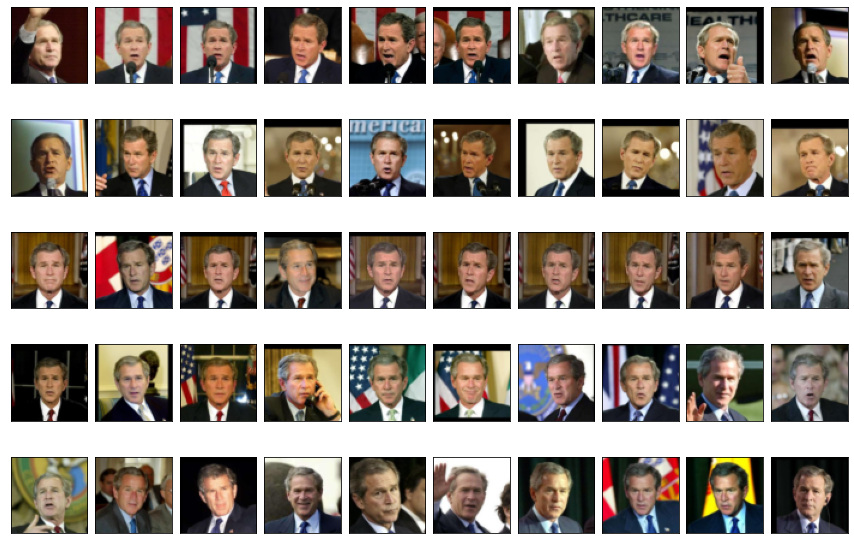

In [25]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [26]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [27]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (Discriminator_net): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (linear): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [28]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (unlinear): Linear(in_features=128, out_features=16384, bias=True)
  (Decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [29]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [30]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

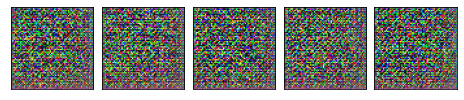

In [31]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [32]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.25, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.02, 'betas': (0.5, 0.99), 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.02, 'betas': (0.5, 0.99), 'lr': 0.0002}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:55<00:00,  3.26s/it]
Discriminator loss: 0.654522610061309
Generator loss:     12.286461030735689


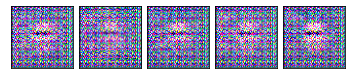

--- EPOCH 2/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.22333538400776246
Generator loss:     14.598165063297047


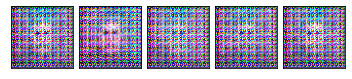

--- EPOCH 3/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: -0.03593845577800975
Generator loss:     13.573579872355742
Saved checkpoint.


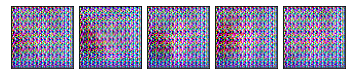

--- EPOCH 4/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.05573059629429789
Generator loss:     10.676551931044635
Saved checkpoint.


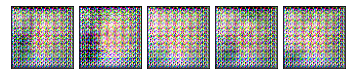

--- EPOCH 5/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.16s/it]
Discriminator loss: 1.1045543926165384
Generator loss:     9.748659989413094
Saved checkpoint.


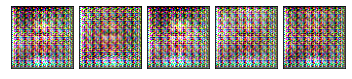

--- EPOCH 6/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.20s/it]
Discriminator loss: 0.14173994837876627
Generator loss:     9.755824509788962


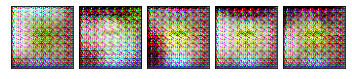

--- EPOCH 7/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.19s/it]
Discriminator loss: 1.0536463799722053
Generator loss:     9.143243018318625
Saved checkpoint.


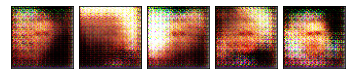

--- EPOCH 8/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.18s/it]
Discriminator loss: 0.8486201175872017
Generator loss:     3.675598418011385
Saved checkpoint.


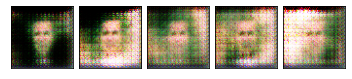

--- EPOCH 9/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.19s/it]
Discriminator loss: 0.6319543912130243
Generator loss:     3.950786324108348


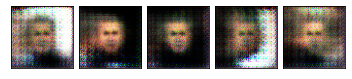

--- EPOCH 10/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.19s/it]
Discriminator loss: 0.7628713679664275
Generator loss:     3.8088335149428425
Saved checkpoint.


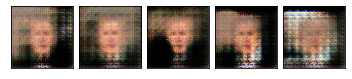

--- EPOCH 11/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.19s/it]
Discriminator loss: 0.7646241575917777
Generator loss:     4.129507864222807


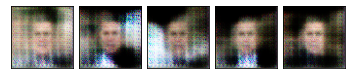

--- EPOCH 12/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.8131325017003452
Generator loss:     4.041349642417011
Saved checkpoint.


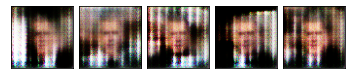

--- EPOCH 13/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.22s/it]
Discriminator loss: 0.6756758348030203
Generator loss:     4.557205754167893


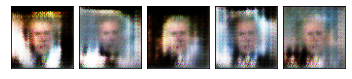

--- EPOCH 14/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.7781198217588312
Generator loss:     4.272862869150498
Saved checkpoint.


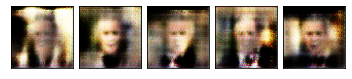

--- EPOCH 15/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.7330964943941902
Generator loss:     3.947721376138575
Saved checkpoint.


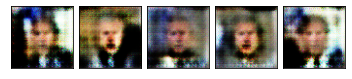

--- EPOCH 16/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.684023099787095
Generator loss:     4.300765191807466


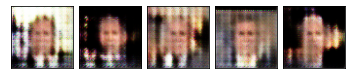

--- EPOCH 17/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.13s/it]
Discriminator loss: 0.7568655846750035
Generator loss:     4.568966690231772


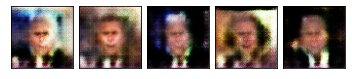

--- EPOCH 18/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 1.03623107250999
Generator loss:     4.597480153336244


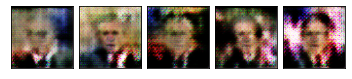

--- EPOCH 19/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.17s/it]
Discriminator loss: 0.6874905053307029
Generator loss:     3.8064518395592186
Saved checkpoint.


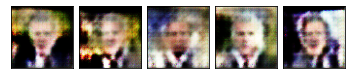

--- EPOCH 20/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.6228027562884724
Generator loss:     4.859652112512028


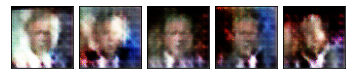

--- EPOCH 21/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.676056839963969
Generator loss:     4.488394204308005
Saved checkpoint.


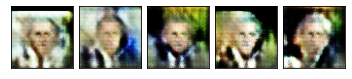

--- EPOCH 22/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.7647634770940331
Generator loss:     4.05512916691163
Saved checkpoint.


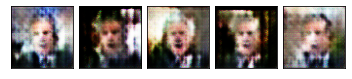

--- EPOCH 23/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.7483851256615975
Generator loss:     4.920800713931813


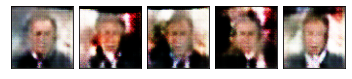

--- EPOCH 24/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.7040155722814447
Generator loss:     4.309424372280345
Saved checkpoint.


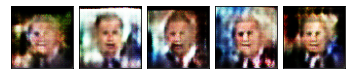

--- EPOCH 25/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.6962440522278056
Generator loss:     4.827496542650111


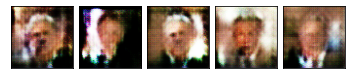

--- EPOCH 26/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.4185477276058758
Generator loss:     4.909994209513945


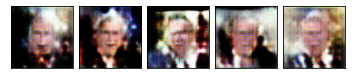

--- EPOCH 27/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.771055610740886
Generator loss:     4.933365990133846


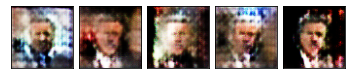

--- EPOCH 28/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 1.015540815451566
Generator loss:     6.058303622638478


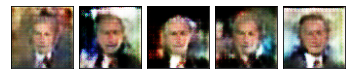

--- EPOCH 29/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.13s/it]
Discriminator loss: 0.5878477727665621
Generator loss:     3.788908004760742
Saved checkpoint.


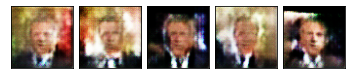

--- EPOCH 30/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.5634470211670679
Generator loss:     5.056743663900039


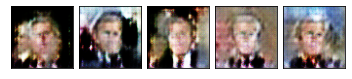

--- EPOCH 31/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.6787040312500561
Generator loss:     4.761795071994557
Saved checkpoint.


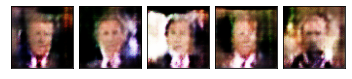

--- EPOCH 32/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.16s/it]
Discriminator loss: 0.6150516484151868
Generator loss:     5.178361864650951


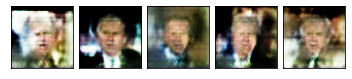

--- EPOCH 33/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.17s/it]
Discriminator loss: 0.31093399686848416
Generator loss:     5.736077575122609


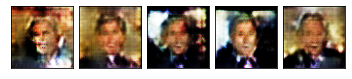

--- EPOCH 34/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.7390962067772361
Generator loss:     5.5622893641976745
Saved checkpoint.


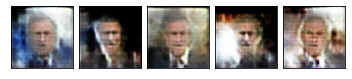

--- EPOCH 35/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.4622240798438297
Generator loss:     5.1406462753520294
Saved checkpoint.


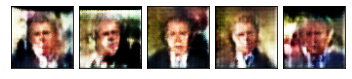

--- EPOCH 36/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.859235733966617
Generator loss:     5.054521785062902
Saved checkpoint.


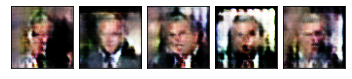

--- EPOCH 37/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.5903261466061368
Generator loss:     5.49016718303456


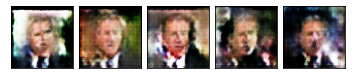

--- EPOCH 38/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.13s/it]
Discriminator loss: 0.791053732528406
Generator loss:     5.219557320370393
Saved checkpoint.


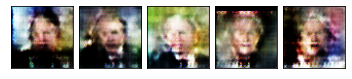

--- EPOCH 39/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.6091273093924803
Generator loss:     4.101923507802627
Saved checkpoint.


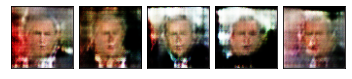

--- EPOCH 40/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.3750955203876776
Generator loss:     5.231617520837223


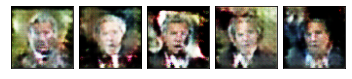

--- EPOCH 41/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.4667158849975642
Generator loss:     5.509744041106281


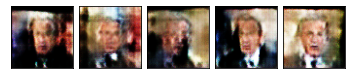

--- EPOCH 42/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.16s/it]
Discriminator loss: 0.5438374771791346
Generator loss:     6.255017785465016


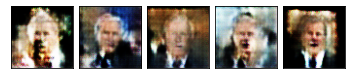

--- EPOCH 43/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.17s/it]
Discriminator loss: 0.45073792601332946
Generator loss:     5.512064260594985
Saved checkpoint.


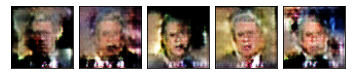

--- EPOCH 44/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.17s/it]
Discriminator loss: 0.49427617253626094
Generator loss:     6.257377568413229


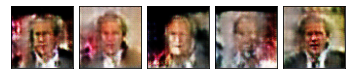

--- EPOCH 45/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.8777668329284471
Generator loss:     6.056402416790233
Saved checkpoint.


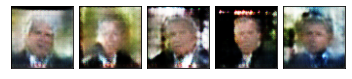

--- EPOCH 46/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.18s/it]
Discriminator loss: 0.548049187835525
Generator loss:     4.917382268344655
Saved checkpoint.


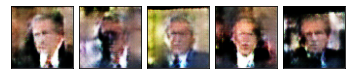

--- EPOCH 47/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.19s/it]
Discriminator loss: 0.4924602642217103
Generator loss:     5.738244800006642


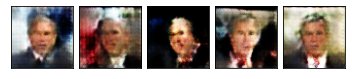

--- EPOCH 48/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.20s/it]
Discriminator loss: 0.40752389676430645
Generator loss:     5.461962798062493
Saved checkpoint.


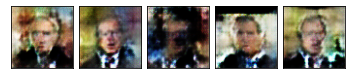

--- EPOCH 49/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.2576742174432558
Generator loss:     6.863963968613568


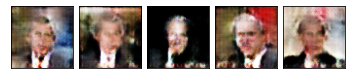

--- EPOCH 50/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.18s/it]
Discriminator loss: 0.2733066583819249
Generator loss:     6.820889276616714
Saved checkpoint.


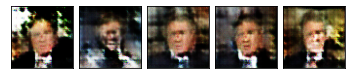

--- EPOCH 51/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.19s/it]
Discriminator loss: 0.15485462217646487
Generator loss:     7.034566598780015


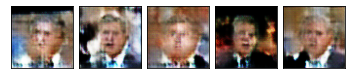

--- EPOCH 52/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.17s/it]
Discriminator loss: 0.704006220707122
Generator loss:     7.22232510061825


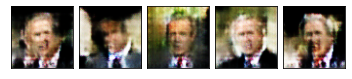

--- EPOCH 53/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.17s/it]
Discriminator loss: 0.49827292824492736
Generator loss:     5.6898492504568665
Saved checkpoint.


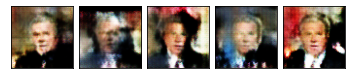

--- EPOCH 54/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.41543541213168816
Generator loss:     5.865881218629725


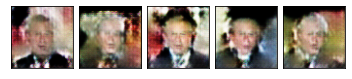

--- EPOCH 55/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.17s/it]
Discriminator loss: 0.6975629535668036
Generator loss:     6.3903522351208855


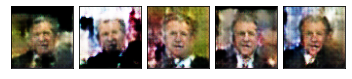

--- EPOCH 56/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.3410011621959069
Generator loss:     5.187495946884155
Saved checkpoint.


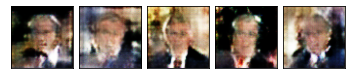

--- EPOCH 57/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]
Discriminator loss: 0.30950239103506594
Generator loss:     5.815307378768921


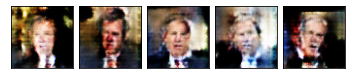

--- EPOCH 58/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.21s/it]
Discriminator loss: 0.1727780700825593
Generator loss:     6.1894455236547135


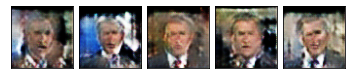

--- EPOCH 59/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.23s/it]
Discriminator loss: 0.5015993197174633
Generator loss:     6.422216527602252


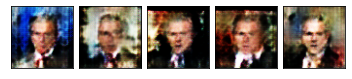

--- EPOCH 60/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.20s/it]
Discriminator loss: 0.40877160955877867
Generator loss:     6.5824096343096565


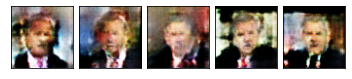

--- EPOCH 61/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.20s/it]
Discriminator loss: 0.24070467931382797
Generator loss:     6.9803565810708434


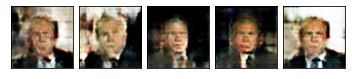

--- EPOCH 62/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.16s/it]
Discriminator loss: 0.36486704965286393
Generator loss:     7.818232339971206


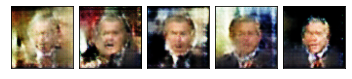

--- EPOCH 63/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.6901496201753616
Generator loss:     4.865243252585916
Saved checkpoint.


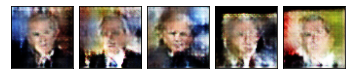

--- EPOCH 64/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.13s/it]
Discriminator loss: 0.6309305394397062
Generator loss:     6.13481385567609


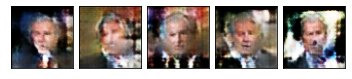

--- EPOCH 65/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.19845442627282703
Generator loss:     5.7662473005407
Saved checkpoint.


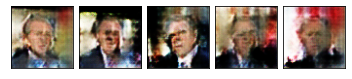

--- EPOCH 66/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.6404043100774288
Generator loss:     6.9021619908949905


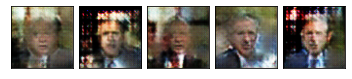

--- EPOCH 67/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.5479022597565371
Generator loss:     4.572475980309879
Saved checkpoint.


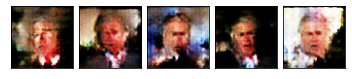

--- EPOCH 68/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.5658485258326811
Generator loss:     5.752406653235941


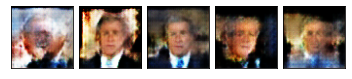

--- EPOCH 69/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.38137920814401965
Generator loss:     6.010662177029778


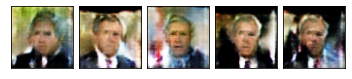

--- EPOCH 70/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.5871514904805842
Generator loss:     6.143241433536305


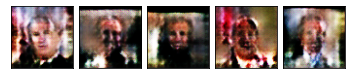

--- EPOCH 71/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.42531607913620334
Generator loss:     5.485474376117482
Saved checkpoint.


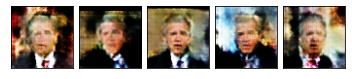

--- EPOCH 72/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.5327824853798923
Generator loss:     5.702421370674582


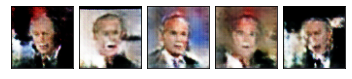

--- EPOCH 73/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:55<00:00,  3.24s/it]
Discriminator loss: 0.4460641391137067
Generator loss:     5.713156812331256


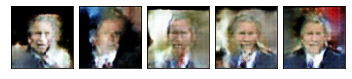

--- EPOCH 74/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.21s/it]
Discriminator loss: 0.2757085334947881
Generator loss:     6.2907584134270165


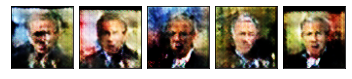

--- EPOCH 75/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.6340012987527777
Generator loss:     5.791013058494119
Saved checkpoint.


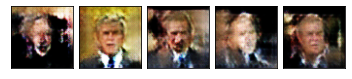

--- EPOCH 76/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.18501512815847115
Generator loss:     5.988572597503662


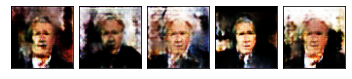

--- EPOCH 77/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.22374109819750576
Generator loss:     6.7744623773238235


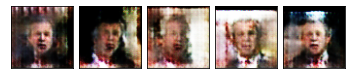

--- EPOCH 78/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.13s/it]
Discriminator loss: 0.21255948920460307
Generator loss:     7.030436137143304


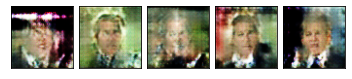

--- EPOCH 79/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.7382440437727115
Generator loss:     6.150415799197028
Saved checkpoint.


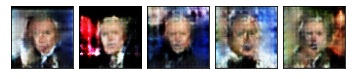

--- EPOCH 80/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.2367615406127537
Generator loss:     5.054595764945535
Saved checkpoint.


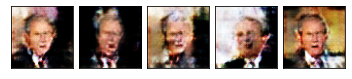

--- EPOCH 81/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.16s/it]
Discriminator loss: 0.659445735571139
Generator loss:     6.557403066579034


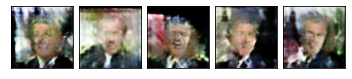

--- EPOCH 82/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.7159573050106273
Generator loss:     4.057213187217712
Saved checkpoint.


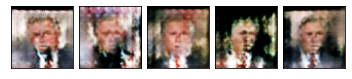

--- EPOCH 83/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.4735731912009856
Generator loss:     4.847351649228265


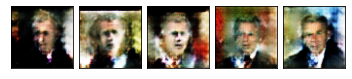

--- EPOCH 84/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.6044345537529272
Generator loss:     5.929222163032083


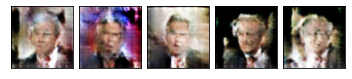

--- EPOCH 85/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.3782735344241647
Generator loss:     4.320787738351261
Saved checkpoint.


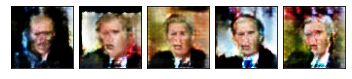

--- EPOCH 86/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.22366329534527132
Generator loss:     6.8439739591935105


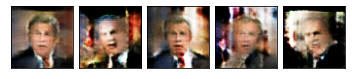

--- EPOCH 87/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.47413746661999645
Generator loss:     6.823749205645393
Saved checkpoint.


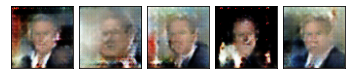

--- EPOCH 88/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.41190574581132217
Generator loss:     5.55465018048006
Saved checkpoint.


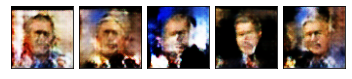

--- EPOCH 89/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.2226055943790604
Generator loss:     6.200506743262796


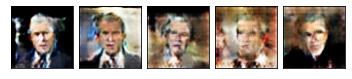

--- EPOCH 90/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.16s/it]
Discriminator loss: 0.33853279382866974
Generator loss:     6.896489059223848


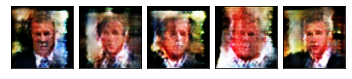

--- EPOCH 91/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.3909723250304951
Generator loss:     6.272499701556037
Saved checkpoint.


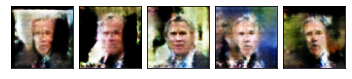

--- EPOCH 92/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.4172017282313284
Generator loss:     6.106812280767104
Saved checkpoint.


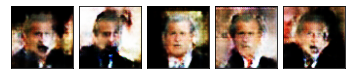

--- EPOCH 93/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.3853334078893942
Generator loss:     6.665804891025319


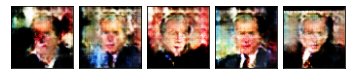

--- EPOCH 94/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.24003888578975902
Generator loss:     5.276483970529893
Saved checkpoint.


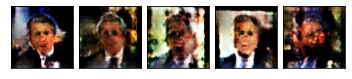

--- EPOCH 95/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.5482033806688645
Generator loss:     5.67362764302422


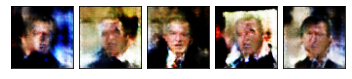

--- EPOCH 96/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.30585725035737543
Generator loss:     5.36010918897741
Saved checkpoint.


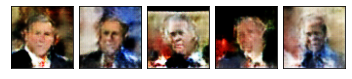

--- EPOCH 97/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.16s/it]
Discriminator loss: 0.30844975942197966
Generator loss:     6.703638301176183


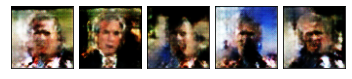

--- EPOCH 98/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.20152648801312728
Generator loss:     7.042827662299661


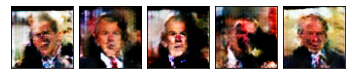

--- EPOCH 99/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.15s/it]
Discriminator loss: 0.2048730837071643
Generator loss:     7.394485501682057


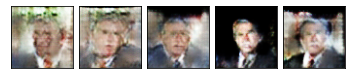

--- EPOCH 100/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.14s/it]
Discriminator loss: 0.2943973131477833
Generator loss:     6.699618956621955
Saved checkpoint.


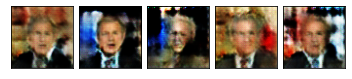

In [33]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [38]:
# For HW #4 mini project...
import pickle
# Save discriminator and generator losses
with open('vanilla_avg_dsc_losses.pkl', 'wb') as f:
    pickle.dump(dsc_avg_losses, f)
    print('Save fild: vanilla_avg_dsc_losses.pkl')
    
with open('vanilla_avg_gen_losses.pkl', 'wb') as f:
    pickle.dump(gen_avg_losses, f)
    print('Save fild: vanilla_avg_gen_losses.pkl')

Save fild: vanilla_avg_dsc_losses.pkl
Save fild: vanilla_avg_gen_losses.pkl


*** Images Generated from best model:


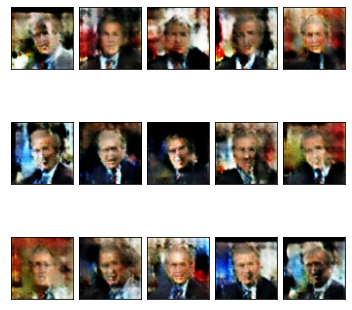

In [34]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

In [35]:
print(gen)
print(checkpoint_file)

Generator(
  (unlinear): Linear(in_features=128, out_features=16384, bias=True)
  (Decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
checkpoints/gan


## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [36]:
from cs236781.answers import display_answer
import hw3.answers

ImportError: cannot import name 'display_answer' from 'cs236781.answers' (C:\Users\Nitzan\Google Drive\CS236781\Homework\hw3\cs236781\answers.py)

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(hw3.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(hw3.answers.part3_q3)

---

לא קשור - סקריפט לפרויקט בתכנון תנועה לפרויקט תכנון תנועה ברובוטים: 🦾

In [80]:
import os
import subprocess
from tqdm import tqdm


# Build? 
# status = subprocess.call('make', shell=True)

# Parameters:
ps = [0.2] #, 0.5, 0.7]
epsilons = [2]
tigth_rates = [0.05, 0.1, 0.2]
env = 'planar' #, 'bridge', 'crisp'  # run seperatlly after updating the cpp code
samples = [600]

# merge options
merge_POIs_method = [0, 1]
# merge_POIs = [0, 1]  # manually defined
distance_thresholds = [0.5, 1, 2, 5]
shared_ratios = [0.25, 0.5, 0.75, 0.9]

# constants:
seed = 1
lazyness = 0

total_parameters_num = len(envs)*len(epsilons)*len(ps)*len(tigth_rates)*len(samples)*len(merge_POIs)*len(merge_criteria)

# Create waitbar
waitbar = tqdm(total = total_parameters_num, position = 0 , leave = True)

# ./app/build graph seed num vertex file to write
# ./app/search graph file to read initial p initial eps tightening rate method file to write

# clean
for eps in epsilons:
    for p in ps:
        for sample in samples:
            # directory folder name: 
            directory = f'{env}_clean'
            # check dir name
            if not os.path.isdir(directory):  # if directory does not exist
                os.mkdir(directory)           # make directory
            merge_algo = 0
            graph_file_name_to_write = f'{directory}/{str(env)}_graph' 
            build_cmd = f'./app/build_graph {str(seed)} {str(sample)} {graph_file_name_to_write} {merge_algo} {merge_algo} {merge_algo}'
            print(build_cmd) # for script testing
            # status = subprocess.call(build_cmd, shell=True)
            
            for tight in tigth_rates:
                search_file_name_to_write = f'{directory}/{str(env)}_rate_{str(tight)}_clean'
                
                search_cmd = f'./app/search_graph {graph_file_name_to_write} {p} {eps} {tight} {lazyness} {search_file_name_to_write} {merge_algo}'
                print(search_cmd) # for script testing
                # status = subprocess.call(search_cmd, shell=True)
                waitbar.update(1)


# marge
merge_algo = 1
for eps in epsilons:
    for p in ps:
        for sample in samples:
            for critetion in merge_POIs_method:
                # directory folder name: 
                if critetion == 0:  # merge + Euclidean distance critetion
                    method = 'dist'
                    directory = f'{env}_{method}_'
                    params = distance_thresholds
                elif critetion == 1:  # merge + LOS criterion
                    method = 'LOS'
                    directory = f'{env}_{method}_'
                    params = shared_ratios
                for param in params:
                    folder = directory + str(param)
                # check dir name

                    if not os.path.isdir(folder):  # if directory does not exist
                        os.mkdir(folder)           # make directory

                    graph_file_name_to_write = f'{folder}/{str(env)}_graph' #?
                    build_cmd = f'./app/build_graph {str(seed)} {str(sample)} {graph_file_name_to_write} {merge_algo} {critetion} {param}' 
                    print(build_cmd) # for script testing
                    for tight in tigth_rates:

                        # status = subprocess.call(build_cmd, shell=True)
                        search_file_name_to_write = f'{folder}/{str(env)}_rate_{str(tight)}_merge_{method}'
                        
                        search_cmd = f'./app/search_graph {graph_file_name_to_write} {p} {eps} {tight} {lazyness} {search_file_name_to_write} {merge_algo}'
                        print(search_cmd) # for script testing
                        # status = subprocess.call(search_cmd, shell=True)
                        waitbar.update(1)

# Close waitbar
waitbar.close()

27it [00:00, 2707.62it/s]                                                                                              

./app/build_graph 1 600 planar_clean/planar_graph 0 0 0
./app/search_graph planar_clean/planar_graph 0.2 2 0.05 0 planar_clean/planar_rate_0.05_clean 0
./app/search_graph planar_clean/planar_graph 0.2 2 0.1 0 planar_clean/planar_rate_0.1_clean 0
./app/search_graph planar_clean/planar_graph 0.2 2 0.2 0 planar_clean/planar_rate_0.2_clean 0
./app/build_graph 1 600 planar_dist_0.5/planar_graph 1 0 0.5
./app/search_graph planar_dist_0.5/planar_graph 0.2 2 0.05 0 planar_dist_0.5/planar_rate_0.05_merge_dist 1
./app/search_graph planar_dist_0.5/planar_graph 0.2 2 0.1 0 planar_dist_0.5/planar_rate_0.1_merge_dist 1
./app/search_graph planar_dist_0.5/planar_graph 0.2 2 0.2 0 planar_dist_0.5/planar_rate_0.2_merge_dist 1
./app/build_graph 1 600 planar_dist_1/planar_graph 1 0 1
./app/search_graph planar_dist_1/planar_graph 0.2 2 0.05 0 planar_dist_1/planar_rate_0.05_merge_dist 1
./app/search_graph planar_dist_1/planar_graph 0.2 2 0.1 0 planar_dist_1/planar_rate_0.1_merge_dist 1
./app/search_graph pl